# Running a Gillespie simulation

## Import the library 

In [1]:
from GillespieSimulator.GillespieEngine import GillespieEngine
from GillespieSimulator.Parameters import Parameters

## Import useful python modules

In [2]:
import shutil, os
from matplotlib import pyplot

## Setup the parameters 

In [3]:
parameters = Parameters(max_time=10,            # run for 10 generations
         division_rate=1.0,                     # one division per time step
         division_rate_fwhm=0.0,                # no variability  in division rate
         mutation_probability=0.05,             # chance for mutation during cell division
         death_rate=0.2,                        # death rate    
         death_rate_fwhm=0.0,                   # variability in death rate
         barcode_size=25,                       # length of barcode sequence
         genome_size=6e6,                       # genome size in bp
         pdf_mean=0.01,                         # center of the pdf from which to draw the competition matrix elements
         pdf_rms=.001,                          # width of the pdf 
         theta=1.0,                             # theta factor in the carry. cap. term, controls by how much the population can overshoot the carr. cap.
         carrying_capacity=1000,                # carrying capacity
         )

## Setup the simulation engine. 

In [4]:
# Setup the path where simulation data will be saved.
output_path = 'gillespie_example_out/'

In [5]:
# Clean up from previous run.
if os.path.isdir(output_path):
    shutil.rmtree(output_path)

In [6]:
# Setup the simulation engine.
engine = GillespieEngine(parameters=parameters,             # parameters from above
                         population=[10, 10, 10],           # initial population: 3 lineages of 10 cells each.
                         outdir=output_path,                # path to store the output datae
                        )    

## Iterate until max_time.

In [7]:
engine.run(snapshot_interval=1) # run the simulation and store 1 snapshot per generation.

## Visualize the data 

### The output data schema


Simulation data is stored in a tree-like format in a json document. The schema is as follows:
```
{"data":
    "parameters":{"time: <float> },
    "random":{"r1": <float>,
              "r2": <float>,
              },
    "data":
        {"conditional_rates": [<float>, len=number of mutants * 4],
         "competition_matrix": [[<float>, len=number of mutants], len=number of mutants],
         "population": [<int>, len=number of mutants],
         "cells": [ {"cell_id": <int>,
                     "mutation_id": <int>,
                     "parent_mutation_ids": [<int>, len=number of parent generations],
                     "date_of_birth": <float>,
                     "number_of_copies": <int>,
                     "division_rate": <float>,
                     "death_rate": <float>}, len=number of mutants]
                     }
         }
}
```

    - `time` is the simulation time at which this snapshot was taken. 
    - `random` stores the two random numbers on the interval `[0,1]` of the Gillespie algorithm.
    - `conditional_rates` is the flattened array of propensities. Let N be the number of mutants at the given time, then
        - elements [0:N) are the propensities for cell division per mutant
        - elements [N:2N) are the propensities for cell division with mutation
        - elements [2N:3N) are the propensities for cell death
        - elements [3N:4N) are the propensities for defeat by any other mutant (including a cell of the same mutant type).
        
    - `cells` is a list of objects with the following attributes:
        - `cell_id`: A unique ID for the barcode lineage.
        - `mutation_id`: A unique ID for the mutant lineage.
        - `parent_mutation_ids`: A list of mutation_ids indicating the ancestral mutants of this one.
        - `date_of_birth`: The time at which this mutation first occured.
        - `number_of_copies`: The number of identical clones of this mutant.
        - `division_rate`: The average number of cell divisions per generation of this mutant.
        - `death_rate`: The average number of cell deaths per generation for this mutant.
        
    
    

### Using the analysis utilities
The GillespieSimulator module come with a number of handy analysis utilites. They are collected in the module `GillespieSimulator.analysis`.

In [8]:
from GillespieSimulator.analysis import *

#### Load snapshots from an output directory 

In [9]:
snaps = load_snapshots(output_path)

#### Get all mutants as a dataframe 

In [10]:
mutants = mutants(snaps)

In [11]:
mutants

Barcode ID           0   1   2    1    2         1              0  ...       \
Mutant ID           0   0   0    1    2    3    4    5    6    7   ...   28   
time (generations)                                                 ...        
0.000000            10  10  10  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN   
1.001466            16  12  16    1    2    1  NaN  NaN  NaN  NaN  ...  NaN   
2.002427            20  16  21    0    0    1    1  NaN  NaN  NaN  ...  NaN   
3.003855            28  18  24    0    0    2    1    1  NaN  NaN  ...  NaN   
4.004238            30  20  15    0    0    0    2    0    0    1  ...  NaN   
5.008207            30  19  18    0    0    0    2    0    0    0  ...  NaN   
6.008319            33  16  10    0    0    0    3    0    0    0  ...  NaN   
7.011769            47  15   4    0    0    0    0    0    0    0  ...  NaN   
8.017360            55  18   5    0    0    0    0    0    0    0  ...    2   
9.046945            46  17   2    0    0    0    0    0    0    0  ...    0   
10.007640           59  21   1    0    0    0    0    0    0    0  ...    0   

Barcode ID                      2    0    1         0    1       
Mutant ID            29   30   31   32   33   34   35   36   37  
time (generations)                                               
0.000000            NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1.001466            NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2.002427            NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
3.003855            NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
4.004238            NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
5.008207            NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
6.008319            NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
7.011769            NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
8.017360              1    1    1  NaN  NaN  NaN  NaN  NaN  NaN  
9.046945              0    0    0    3    0    1  NaN  NaN  NaN  
10.007640             0    0    0    3    0    2    1    0    0  

[11 rows x 40 columns]

#### Get the barcode frequencies
Once we have the mutant frequencies (see above), we can easily calculate the barcode frequencies simply by grouping on the Barcode ID (aka `cell_id`) and summing up the frequencies:

In [12]:
counts = mutants.groupby(axis=1, level='Barcode ID').sum()

In [13]:
counts

Barcode ID             0     1     2
time (generations)                  
0.000000            10.0  10.0  10.0
1.001466            16.0  13.0  19.0
2.002427            20.0  17.0  22.0
3.003855            28.0  20.0  26.0
4.004238            32.0  26.0  15.0
5.008207            30.0  28.0  18.0
6.008319            35.0  28.0  12.0
7.011769            51.0  25.0   4.0
8.017360            62.0  23.0   7.0
9.046945            53.0  18.0   4.0
10.007640           66.0  23.0   1.0

#### Count the number of mutations vs. time 
In the same way, we can obtain the number of mutations that occured in each barcode lineage by grouping again on the Barcode ID and counting the mutants.


In [14]:
mutations = mutants.groupby(axis=1, level='Barcode ID').count()

In [15]:
mutations

Barcode ID           0   1  2
time (generations)           
0.000000             1   1  1
1.001466             1   2  3
2.002427             1   3  3
3.003855             1   4  3
4.004238             3   8  3
5.008207             3   9  4
6.008319             5  11  6
7.011769             7  12  6
8.017360            13  13  8
9.046945            14  15  8
10.007640           15  17  8

#### The interactive plotting tool
The analysis module contains an interactive plotting tool to analyse the mutant frequencies, barcode frequencies, and mutations as well as the competition matrix for a series of simulation runs. 

In [16]:
display(interactive_plot_widget({0:snaps}))

For the static version of this notebook, here is a screenshot of the widget above: 
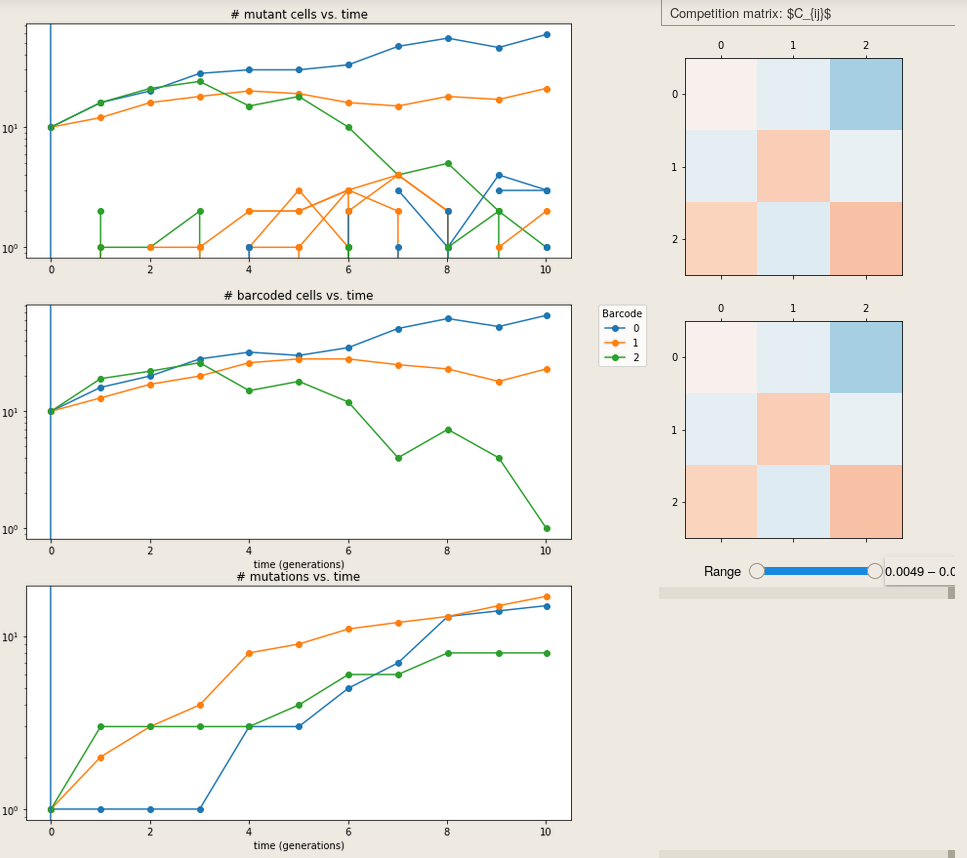

The top left panel shows the mutant frequencies vs. time. Mutants that carry the same barcode are plotted with the same color. The middle left panel shows the barcode frequencies vs. time and the bottom left panel shows the number of mutations per barcode vs. time.

The right upper panel shows the competition matrix $C_{ij}$ at the selected snapshot. The snapshot time can be selected in the slider widget on top of the right panels. In the visualisation, the competition matrix' elements are blocked according to barcode IDs, hence the row and column index do not correspond to the actual mutation ID. This is to visualize more clearly how the barcode IDs 'compete' with each other. The bottom panel on the right side shows the competition matrix averaged over each block of mutants with the same barcode ID. To interpret this visualization, it is helpful to keep in mind that the competiton matrix element (competition coefficient) $C_{ij}$ gives the rate at which mutants of type $j$ defeat mutants of type $i$. The first index gives the row number of the competition matrix, the second index gives the column number. Blue color means a below-average competition coefficient, red means an above-average competition coefficient. A column with lots of red in its rows indicates high competitive fitness of that mutant (barcode) over the other mutants (barcodes), respectively. However, this can only be used as a rough rule of thumb because ultimately, not the competition matrix but the competition propensities, i.e. competition matrix weighted by mutant frequencies determine the probability of a given event to occur.

An interactive version of this notebook is served at https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.gwdg.de%2Fmpievolbio-scicomp%2Fgillespiesimulator.git/master?filepath=doc%2Fsource%2Finclude%2Fnotebooks%2FGillespieExample.ipynb